In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# === Config ===
GRID_SIZE = 5
CELL_SIZE = 0.3 # m
NUM_ORIENT = 72
LAMBDA_POS = 1.0
LAMBDA_ORI = 2.0

def action_to_pose(action_id):
    ang = action_id % NUM_ORIENT
    idx = action_id // NUM_ORIENT
    row, col = divmod(idx, GRID_SIZE)
    x = (col - GRID_SIZE // 2) * CELL_SIZE
    y = (row - GRID_SIZE // 2) * CELL_SIZE
    theta = ang * (360.0 / NUM_ORIENT)
    return [x, y, theta]

def pose_error(pred, gt, λ_pos=LAMBDA_POS, λ_ori=LAMBDA_ORI):
    dx, dy = pred[0] - gt[0], pred[1] - gt[1]
    pos_err = (dx**2 + dy**2)**0.5
    ori_err = abs((pred[2] - gt[2] + 180) % 360 - 180)
    return λ_pos * pos_err**2 + λ_ori * (ori_err / 180.0)**2

def analyze_logs(root_dir):
    records = []
    # grid covers [−(GRID_SIZE*CELL_SIZE)/2, +(GRID_SIZE*CELL_SIZE)/2]
    offset = (GRID_SIZE * CELL_SIZE) / 2.0

    for traj_folder in sorted(os.listdir(root_dir)):
        traj_path = os.path.join(root_dir, traj_folder)
        log_path  = os.path.join(traj_path, "log.csv")
        if not os.path.isfile(log_path):
            continue

        try:
            df = pd.read_csv(log_path)
            for _, row in df.iterrows():
                if 'action_id' not in row or pd.isna(row['action_id']):
                    continue

                action_id = int(row["action_id"])
                gt_x  = float(row["rel_x"])
                gt_y  = float(row["rel_y"])
                gt_th = float(row["rel_theta"])

                # compute pose error
                pred_pose = action_to_pose(action_id)
                err = pose_error(pred_pose, [gt_x, gt_y, gt_th])

                # convert ground‐truth (x,y) into 5×5 cell bins
                x_bin = int(np.floor((gt_x + offset) / CELL_SIZE))
                y_bin = int(np.floor((gt_y + offset) / CELL_SIZE))
                x_bin = min(max(x_bin, 0), GRID_SIZE-1)
                y_bin = min(max(y_bin, 0), GRID_SIZE-1)

                theta_bin = action_id % NUM_ORIENT

                records.append({
                    "x_bin":      x_bin,
                    "y_bin":      y_bin,
                    "theta_bin":  theta_bin,
                    "pose_error": err
                })
        except Exception as e:
            print(f"[WARN] Skipped {traj_path}: {e}")

    return pd.DataFrame(records)

def plot_pose_error_maps(df):
    # Heatmap of average pose error per (x, y)
    plt.figure(figsize=(6, 5))
    heatmap = df.groupby(["y_bin", "x_bin"])["pose_error"].mean().unstack()
    sns.heatmap(heatmap, annot=True, fmt=".3f", cmap="Reds")
    plt.title("Average Pose Error per (x, y) Bin")
    plt.xlabel("x_bin")
    plt.ylabel("y_bin")
    plt.tight_layout()
    plt.show()

    # Barplot of average pose error per theta_bin
    plt.figure(figsize=(10, 4))
    theta_avg = df.groupby("theta_bin")["pose_error"].mean()
    sns.barplot(x=theta_avg.index, y=theta_avg.values, color="salmon")
    plt.title("Average Pose Error per Orientation Bin")
    plt.xlabel("theta_bin")
    plt.ylabel("Avg Pose Error")
    plt.tight_layout()
    plt.show()

def plot_cell_orientation_histograms(df):
    """
    Plot a 5×5 grid of cells where:
      - x (row index) is vertical ↑ (north),
      - y (col index) is horizontal → (east).
    Each cell shows a histogram of orientation angles in [-180,180],
    and the bottom row displays x-ticks.
    Cell background color encodes sample count.
    """
    # compute counts per cell
    counts_xy = (
        df.groupby(['x_bin','y_bin'])
          .size()
          .unstack(fill_value=0)
          .reindex(index=range(GRID_SIZE),
                   columns=range(GRID_SIZE),
                   fill_value=0)
    )

    # collect raw 0→360° angles per cell
    angles_xy = {
        (x, y): (
            df.loc[(df.x_bin==x)&(df.y_bin==y), 'theta_bin']
              * (360.0/NUM_ORIENT)
        ).values
        for x in range(GRID_SIZE)
        for y in range(GRID_SIZE)
    }

    # prepare colormap
    vmax = counts_xy.values.max()
    norm = mcolors.Normalize(vmin=0, vmax=vmax)
    cmap = plt.cm.Reds

    # square figure + constrained layout for roughly square subplots
    fig, axes = plt.subplots(
        GRID_SIZE, GRID_SIZE,
        figsize=(10,10),
        subplot_kw={'projection':'polar'},
        constrained_layout=True
    )

    # build 13 bins around the circle
    num_bins  = 26
    bin_edges = np.linspace(0, 2*np.pi, num_bins+1)

    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            ax = axes[GRID_SIZE-1-x, y]
            thetas = np.deg2rad(angles_xy[(x, y)])
            ax.hist(thetas, bins=bin_edges, color='k', alpha=0.7)
            ax.set_yticks([])
            ax.set_theta_zero_location('N')   # zero at top
            ax.set_theta_direction(-1)        # clockwise
            ax.set_facecolor(cmap(norm(counts_xy.at[x,y])))

    # Overlay a grid on the array of rose plots
    for i in range(GRID_SIZE+1):
        # Horizontal lines
        fig.add_artist(plt.Line2D(
            [0, 1], [i / GRID_SIZE, i / GRID_SIZE],
            color='gray', linewidth=1, alpha=0.7, transform=fig.transFigure, zorder=100
        ))
        # Vertical lines
        fig.add_artist(plt.Line2D(
            [i / GRID_SIZE, i / GRID_SIZE], [0, 1],
            color='gray', linewidth=1, alpha=0.7, transform=fig.transFigure, zorder=100
        ))

    # Adjust layout to make space for suptitle and colorbar
    plt.subplots_adjust(top=1.90, bottom=0.10)

    # main title
    plt.suptitle('Orientation Distributions (0° at top center)',y=1.02)

    # colorbar in the newly freed space at the very bottom
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.15, -0.07, 0.7, 0.025])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.set_label('Sample Count')

    plt.show()

Loaded 40896 pose samples from logs.


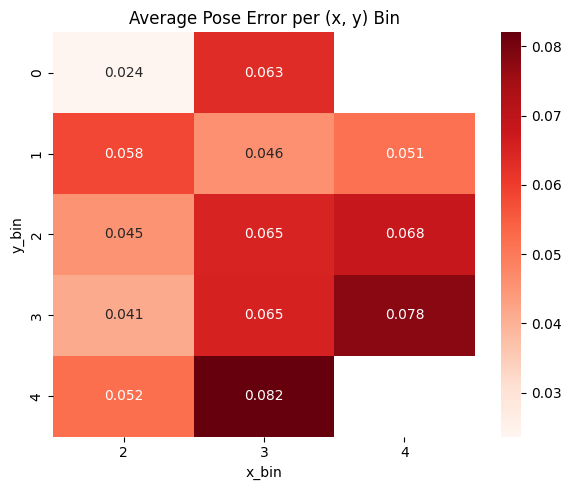

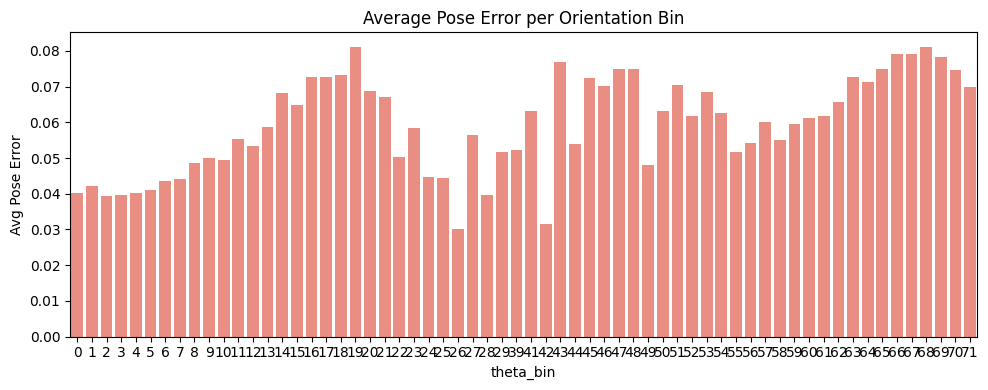

/tmp/ipykernel_3880779/2926275648.py:166: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=1.90, bottom=0.10)


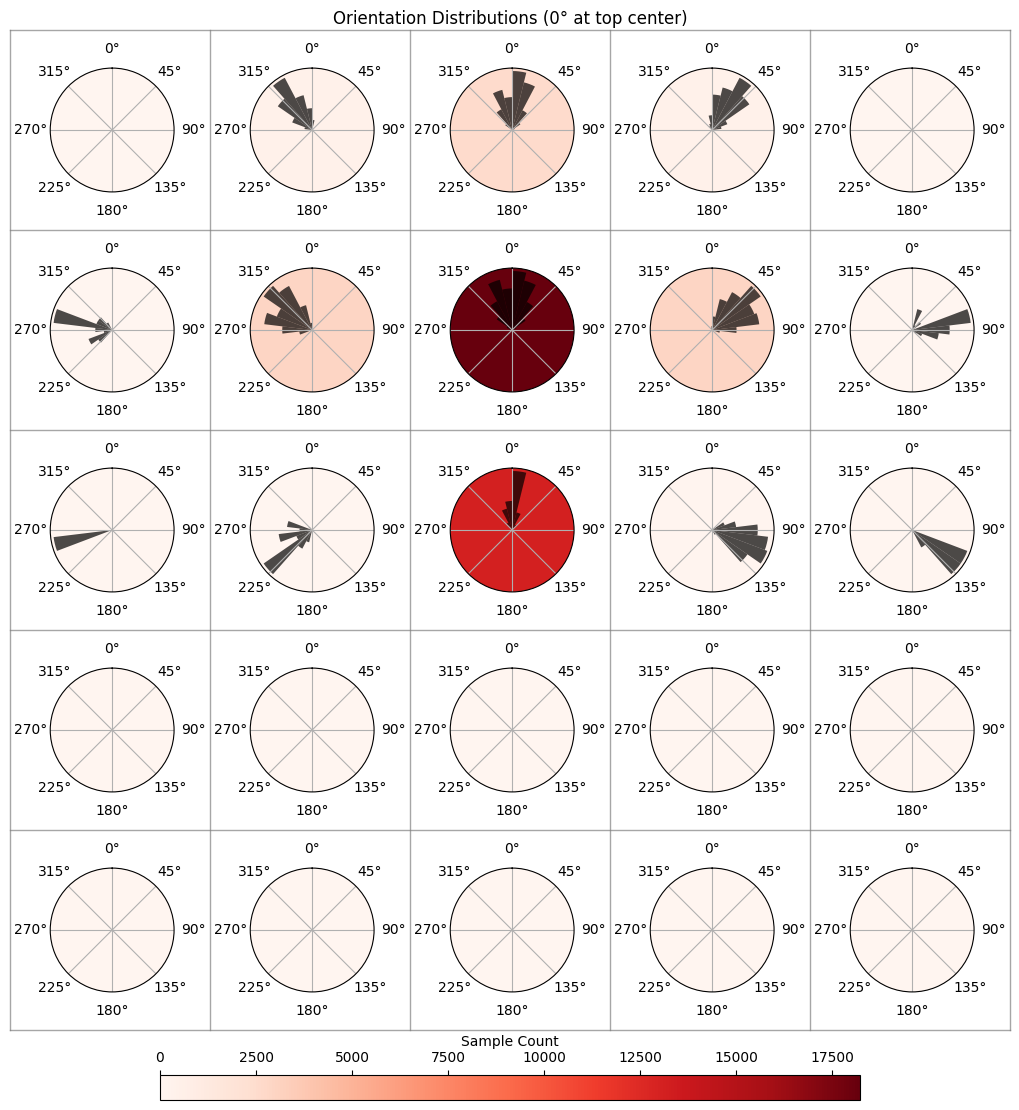

In [2]:
# === Run it ===
#if __name__ == "__main__":
ROOT_DIR = "/data/students/earl/ai322/rldr/trajectories"  # Change this
df = analyze_logs(ROOT_DIR)
print(f"Loaded {len(df)} pose samples from logs.")
plot_pose_error_maps(df)
plot_cell_orientation_histograms(df)
